# ML Project: Creditworthiness Estimation Model 💳 <a class="tocSkip">

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Exploration-and-Preprocessing" data-toc-modified-id="Data-Exploration-and-Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Exploration and Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Target-Estimation" data-toc-modified-id="Target-Estimation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Target Estimation</a></span></li><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data Preprocessing</a></span></li></ul></li><li><span><a href="#Model-Building" data-toc-modified-id="Model-Building-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model Building</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Random-Forests-and-Gradient-Boosting-Trees" data-toc-modified-id="Random-Forests-and-Gradient-Boosting-Trees-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Random Forests and Gradient Boosting Trees</a></span><ul class="toc-item"><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Balanced-Random-Forest" data-toc-modified-id="Balanced-Random-Forest-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Balanced Random Forest</a></span></li></ul></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>XGBoost</a></span></li></ul></li><li><span><a href="#Interpreting-the-Final-Model" data-toc-modified-id="Interpreting-the-Final-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Interpreting the Final Model</a></span></li></ul></div>

# Data Exploration and Preprocessing

In [1]:
import numpy as np
import pandas as pd
from utils import *

pd.options.mode.chained_assignment = None

## Target Estimation

Let us start by importing the dataframe contained in `credit_record.csv`:

In [2]:
credit_df = pd.read_csv("credit_record.csv")
credit_df

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


The data contained in this dataframe are:
* `ID`: Client number;
* `MONTHS_BALANCE`: The month of the extracted data is the starting point, backwards: 0 is the current month, -1 is the previous month, and so on;
* `STATUS`: 
    * 0: 1-29 days past due;
    * 1: 30-59 days past due;
    * 2: 60-89 days overdue;
    * 3: 90-119 days overdue;
    * 4: 120-149 days overdue;
    * 5: overdue or bad debts, write-offs for more than 150 days;
    * C: paid off that month;
    * X: no loan for the month.

In [3]:
credit_df["ID"].nunique()

45985

Therefore, we have credit status information for 45,985 customers over varying time periods.

Let us group the `credit_df` DataFrame by customer ID and create a pivot table, `pivot_tb`, where each cell represents a customer's credit status at a specific month:

In [4]:
grouped_df = credit_df.groupby('ID')
pivot_tb = credit_df.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')
pivot_tb

MONTHS_BALANCE,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,...,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
ID,,,,,,,,,,,,,,,,,,,,,
5001711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,X
5001712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,C,C,C,C,C,C,C,C,C
5001713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,X,X,X,X,X,X,X,X,X,X
5001714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,X,X,X,X,X,X,X,X,X,X
5001715,NaN,X,X,X,X,X,X,X,X,X,...,X,X,X,X,X,X,X,X,X,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5150482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5150483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,X,X,X,X,X,X,X,X,X,X
5150484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,C


For each ID, let us compute the `open_month` and `end_month` variables, indicating the month when the account was opened and the last month for which we have data, respectively:

In [5]:
pivot_tb['open_month'] = grouped_df['MONTHS_BALANCE'].min()
pivot_tb['end_month'] = grouped_df['MONTHS_BALANCE'].max()
pivot_tb

MONTHS_BALANCE,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,...,-7,-6,-5,-4,-3,-2,-1,0,open_month,end_month
ID,,,,,,,,,,,,,,,,,,,,,
5001711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,X,-3,0
5001712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,C,C,C,C,C,C,C,C,-18,0
5001713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,X,X,X,X,X,X,X,X,-21,0
5001714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,X,X,X,X,X,X,X,X,-14,0
5001715,NaN,X,X,X,X,X,X,X,X,X,...,X,X,X,X,X,X,X,X,-59,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5150482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-28,-11
5150483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,X,X,X,X,X,X,X,X,-17,0
5150484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,C,-12,0


From the latter two variables, the `window` can be built, providing information on the time period for which we have data:

In [6]:
pivot_tb['ID'] = pivot_tb.index
pivot_tb = pivot_tb[['ID', 'open_month', 'end_month']]
pivot_tb.loc[:, 'window'] = pivot_tb['end_month'] - pivot_tb['open_month']
pivot_tb.reset_index(drop = True, inplace = True)
pivot_tb

MONTHS_BALANCE,ID,open_month,end_month,window
0,5001711,-3,0,3
1,5001712,-18,0,18
2,5001713,-21,0,21
3,5001714,-14,0,14
4,5001715,-59,0,59
...,...,...,...,...
45980,5150482,-28,-11,17
45981,5150483,-17,0,17
45982,5150484,-12,0,12
45983,5150485,-1,0,1


Finally, let us merge the `credit_df` DataFrame with the `pivot_tb` DataFrame using a left join:

In [7]:
credit_df = pd.merge(credit_df, pivot_tb, on = 'ID', how = 'left')
credit_df

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,window
0,5001711,0,X,-3,0,3
1,5001711,-1,0,-3,0,3
2,5001711,-2,0,-3,0,3
3,5001711,-3,0,-3,0,3
4,5001712,0,C,-18,0,18
...,...,...,...,...,...,...
1048570,5150487,-25,C,-29,0,29
1048571,5150487,-26,C,-29,0,29
1048572,5150487,-27,C,-29,0,29
1048573,5150487,-28,C,-29,0,29


In [8]:
credit_df["window"].max()

60

To classify a customer as 'good' or 'bad,' it is necessary to determine an appropriate **performance window**.

If the observation window is too short, users' behavior may not fully manifest, leading to unnecessary noise in our data. Therefore, only customers with an observation window longer than the performance window will be considered, and the latter will be defined as the period during which the event rate stabilizes, meaning that the event rate does not increase significantly.

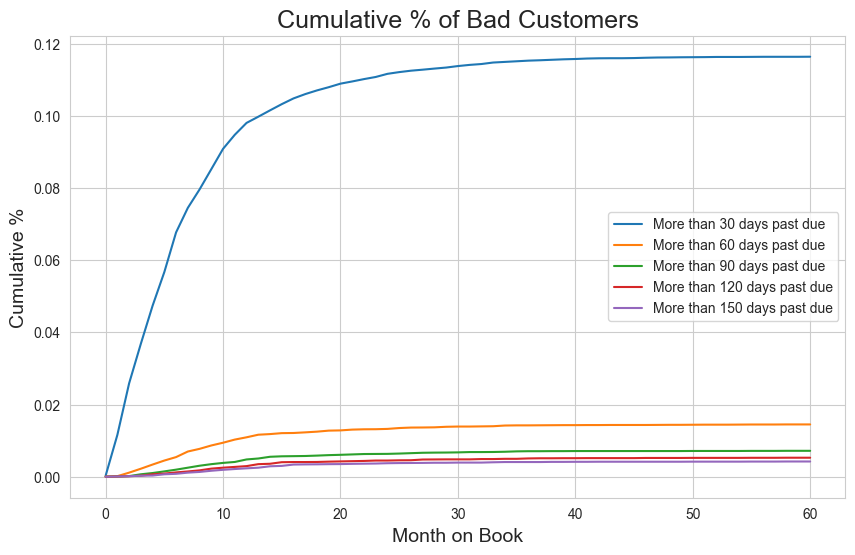

In [9]:
plot_cumulative_percentages(credit_df)

In [10]:
morethan60_command = "credit.loc[(credit['STATUS'] == '2') | (credit['STATUS'] == '3' ) | " \
    " (credit['STATUS'] == '4' ) | (credit['STATUS'] == '5'), 'status'] = 1"
performance_window = get_performance_window(credit_df, morethan60_command)
performance_window

21

Therefore, using "more than 60 days past due" as status to identify a bad customer, the performance window (defined as the first month on book at which the event rate is greater than or equal to the 90% of the total event rate) is set to 21, and all the customers with an observation window shorter than the performance window are excluded from the analysis:

In [11]:
credit_df = credit_df[credit_df['window'] >= performance_window]
# 0: < 60 days past due, 1: > 60 days past due 
credit_df['status'] = np.where((credit_df['STATUS'] == '2' ) | (credit_df['STATUS'] == '3' ) | (credit_df['STATUS'] == '4' ) | (credit_df['STATUS'] == '5'), 1, 0) 
credit_df.loc[:, 'status'] = credit_df['status'].astype(np.int8)
# Calculate month on book: how many months after opening account
credit_df['month_on_book'] = credit_df['MONTHS_BALANCE'] - credit_df['open_month'] 
credit_df.sort_values(by = ['ID','month_on_book'], inplace = True)
credit_df

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,window,status,month_on_book
44,5001713,-21,X,-21,0,21,0,0
43,5001713,-20,X,-21,0,21,0,1
42,5001713,-19,X,-21,0,21,0,2
41,5001713,-18,X,-21,0,21,0,3
40,5001713,-17,X,-21,0,21,0,4
...,...,...,...,...,...,...,...,...
1048549,5150487,-4,C,-29,0,29,0,25
1048548,5150487,-3,C,-29,0,29,0,26
1048547,5150487,-2,C,-29,0,29,0,27
1048546,5150487,-1,C,-29,0,29,0,28


In [12]:
bad_customer_ids = credit_df[credit_df['status'] == 1]['ID'].unique()
len(bad_customer_ids)

492

In [13]:
bad_customer_df = pd.DataFrame({'ID': credit_df['ID'].unique()})
bad_customer_df['bad_customer'] = bad_customer_df['ID'].isin(bad_customer_ids).astype(np.int8)
bad_customer_df

,ID,bad_customer
0,5001713,0
1,5001715,0
2,5001717,0
3,5001718,0
4,5001719,0
...,...,...
20919,5150475,0
20920,5150476,0
20921,5150480,0
20922,5150481,0


We are now ready to merge `bad_customer_df` with the dataset providing information on customers, in order to train a ML model to decide whether to issue a credit card to the applicant.

## Data Preprocessing

We start by importing the `application_df` dataset:

In [14]:
application_df = pd.read_csv("application_record.csv")
application_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


It is made of 438,557 samples and 18 columns:

1. `ID`: Client number;
2. `CODE_GENDER`: Gender;
3. `FLAG_OWN_CAR`: Is there a car;
4. `FLAG_OWN_REALTY`: Is there a property;
5. `CNT_CHILDREN`: Number of children;
6. `AMT_INCOME_TOTAL`: Annual income;
7. `NAME_INCOME_TYPE`: Income category (Working, Commercial associate, Pensioner, State servant, Student);
8. `NAME_EDUCATION_TYPE`: Education level (Secondary/secondary special, Higher education, Incomplete higher, Lower secondary, Academic degree);
9. `NAME_FAMILY_STATUS`: Marital status (Married, Single/not married, Civil marriage, Separated, Widow);
10. `NAME_HOUSING_TYPE`: Way of living (House/apartment, With parents, Municipal apartment, Rented apartment, Office apartment, Co-op apartment);
11. `DAYS_BIRTH`: Birthday. Count backwards from current day(0), -1 means yesterday;
12. `DAYS_EMPLOYED`: Start date of employment. Count backwards from current day(0). If positive, it means the person is currently unemployed;
13. `FLAG_MOBIL`: Is there a mobile phone;
14. `FLAG_WORK_PHONE`: Is there a work phone;
15. `FLAG_PHONE`: Is there a phone;
16. `FLAG_EMAIL`: Is there an email;
17. `OCCUPATION_TYPE`: Occupation;
18. `CNT_FAM_MEMBERS`: Family size.

In [15]:
len(set(application_df['ID']))

438510

In [16]:
len(set(application_df['ID']).intersection(set(bad_customer_df["ID"])))

15166

Therefore, even though there are 438,510 IDs in `application_df`, the ones that are present both in the latter and in `bad_customer_df` are 15,166. Let us merge the two dataframes through an inner join, to keep only the rows associated with the common IDs: 

In [17]:
final_df = pd.merge(bad_customer_df, application_df, on = 'ID', how = 'inner')
final_df

,ID,bad_customer,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008806,0,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
1,5008810,0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
2,5008811,0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
3,5008825,0,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,-10669,-1103,1,0,0,0,Accountants,2.0
4,5008826,0,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,-10669,-1103,1,0,0,0,Accountants,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15161,5150475,0,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0
15162,5150476,0,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0
15163,5150480,0,F,Y,Y,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-10808,-1739,1,0,0,0,Core staff,3.0
15164,5150481,0,F,Y,Y,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-10808,-1739,1,0,0,0,Core staff,3.0


In [18]:
final_df["bad_customer"].value_counts()

bad_customer
0    14722
1      444
Name: count, dtype: int64

In [19]:
counts = np.array(np.unique(final_df.bad_customer, return_counts=True)).T
total_counts = np.sum(counts[:,1])
counts_0 = counts[0,1]/total_counts
counts_1 = counts[1,1]/total_counts
print(f"Percentage of good customers: {counts_0*100:.2f} %")
print(f"Percentage of bad customers: {counts_1*100:.2f} %")

Percentage of good customers: 97.07 %
Percentage of bad customers: 2.93 %


Before preprocessing the features of the problem, we create the `y` variable and remove the `bad_customer` variable from the dataframe:

In [20]:
y = final_df["bad_customer"].values
final_df.drop("bad_customer", axis=1, inplace=True)

Let's start our analysis by checking whether there are duplicate values for the `ID` variable:

In [21]:
len(set(final_df['ID'])), len(final_df)

(15166, 15166)

Therefore, there are no duplicate values.

We now consider the `DAYS_EMPLOYED` variable:

In [22]:
final_df[final_df["DAYS_EMPLOYED"]>0]["DAYS_EMPLOYED"].value_counts()

DAYS_EMPLOYED
365243    2465
Name: count, dtype: int64

In [23]:
unemployed_ratio = final_df[final_df["DAYS_EMPLOYED"]>0]["DAYS_EMPLOYED"].value_counts().values[0]/len(final_df)
unemployed_ratio

0.16253461690623763

Recall that a positive value in the `DAYS_EMPLOYED` column indicates that the person is currently unemployed. Therefore, it can be observed that around 16% of the analyzed customers are currently unemployed.

Furthermore, as expected, `OCCUPATION_TYPE` is null for the unemployed customers:

In [24]:
final_df[final_df["DAYS_EMPLOYED"]>0]["OCCUPATION_TYPE"].isna().sum()

2465

We might assign it the value "Unemployed":

In [25]:
final_df.loc[final_df["DAYS_EMPLOYED"]>0,"OCCUPATION_TYPE"] = "Unemployed"

Regarding the `DAYS_EMPLOYED` variable, let's write a code snippet to perform a data quality check. We'll check whether `DAYS_BIRTH` is consistently greater than `DAYS_EMPLOYED`. In a valid dataset, the age of a person (`DAYS_BIRTH`) should always be greater than the number of days employed (`DAYS_EMPLOYED`), as a person should be born before they start working.

We'll identify and remove any rows that don't meet this condition. This ensures data integrity and accuracy in our analysis. Here's the code to achieve this:

In [26]:
invalid_rows = final_df[(abs(final_df['DAYS_BIRTH']) <= abs(final_df['DAYS_EMPLOYED'])) & (final_df["DAYS_EMPLOYED"]<=0)]
print(f"Number of rows before: {len(final_df)}")
final_df.drop(invalid_rows.index, inplace=True)
print(f"Number of rows after: {len(final_df)}")

Number of rows before: 15166
Number of rows after: 15166


To conclude with `DAYS_BIRTH` and `DAYS_EMPLOYED` variables, let's convert them into years, renaming the 2 columns to `AGE` and `YEARS_EMPLOYED`. For the unemployed customers, the value of `YEARS_EMPLOYED` has been set to 0:

In [27]:
convert_days_to_years(final_df, "DAYS_BIRTH", "AGE")
convert_days_to_years(final_df, "DAYS_EMPLOYED", "YEARS_EMPLOYED")

In [28]:
final_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,YEARS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,59,3,1,0,0,0,Security staff,2.0
1,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52,8,1,0,1,1,Sales staff,1.0
2,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52,8,1,0,1,1,Sales staff,1.0
3,5008825,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,29,3,1,0,0,0,Accountants,2.0
4,5008826,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,29,3,1,0,0,0,Accountants,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15161,5150475,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,30,4,1,1,0,0,Laborers,2.0
15162,5150476,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,30,4,1,1,0,0,Laborers,2.0
15163,5150480,F,Y,Y,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,30,5,1,0,0,0,Core staff,3.0
15164,5150481,F,Y,Y,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,30,5,1,0,0,0,Core staff,3.0


In [29]:
max_years_employed = final_df["YEARS_EMPLOYED"].max()
int(max_years_employed)

43

The highest (absolute) value for days of employment corresponds to 43 years, which appears plausible, indicating the absence of anomalous values. A similar check on `DAYS_BIRTH` gives a minimum age of 22 and maximum age of 69, which are also plausible:

In [30]:
min_age = final_df["AGE"].min()
max_age = final_df["AGE"].max()
int(min_age), int(max_age)

(22, 69)

Let's now check if there are **missing values** in the dataset:

In [31]:
columns_with_missing = final_df.columns[final_df.isna().any()]
final_df[columns_with_missing]

,OCCUPATION_TYPE
0,Security staff
1,Sales staff
2,Sales staff
3,Accountants
4,Accountants
...,...
15161,Laborers
15162,Laborers
15163,Core staff
15164,Core staff


In [32]:
final_df.OCCUPATION_TYPE.value_counts(), final_df.OCCUPATION_TYPE.nunique()

(OCCUPATION_TYPE
 Laborers                 2557
 Unemployed               2465
 Core staff               1517
 Sales staff              1359
 Managers                 1338
 Drivers                   955
 High skill tech staff     659
 Medicine staff            550
 Accountants               503
 Cooking staff             259
 Security staff            232
 Cleaning staff            213
 Private service staff     120
 Low-skill Laborers         64
 Secretaries                63
 Waiters/barmen staff       49
 HR staff                   30
 IT staff                   27
 Realty agents              17
 Name: count, dtype: int64,
 19)

In [33]:
print(f"Proportion of missing values in OCCUPATION_TYPE: {(final_df[columns_with_missing].isna().sum().sum()/len(final_df))*100:.1f} %")

Proportion of missing values in OCCUPATION_TYPE: 14.4 %


The only column with missing values is `OCCUPATION_TYPE`, which has 19 different categories. As a start, it is decided to remove the variable from the dataset:

In [34]:
final_df.drop("OCCUPATION_TYPE", axis=1, inplace=True)

Furthermore, due to the single constant value (1) of `FLAG_MOBIL`, it has been chosen for its removal:

In [35]:
final_df["FLAG_MOBIL"].value_counts()

FLAG_MOBIL
1    15166
Name: count, dtype: int64

In [36]:
final_df.drop("FLAG_MOBIL", axis=1, inplace=True)

In addition, we update the column names that begin with `NAME_` by removing this prefix and remove the `ID` variable from the dataframe:

In [37]:
final_df.rename(columns={
    'NAME_HOUSING_TYPE': 'HOUSING_TYPE',
    'NAME_INCOME_TYPE': 'INCOME_TYPE',
    'NAME_EDUCATION_TYPE': 'EDUCATION_TYPE',
    'NAME_FAMILY_STATUS': 'FAMILY_STATUS'
}, inplace=True)
final_df.drop("ID", axis=1, inplace=True)

After exploring the columns of the dataframe, it is decided to create a preprocessing function that performs all the following transformations on the data: 
* The two flag features `FLAG_OWN_CAR` and `FLAG_OWN_REALTY` are encoded using LabelEncoder, converting 'N' to 0 (No) and 'Y' to 1 (Yes). `FLAG_WORK_PHONE`, `FLAG_PHONE`, and `FLAG_EMAIL` are already encoded.
* Gender information in `CODE_GENDER` is similarly encoded, with 'F' denoting 0 for Female and 'M' representing 1 for Male.
* Education levels found in `NAME_EDUCATION_TYPE` are ordinal-encoded based on a predefined order. This ensures that 'Lower secondary' holds the lowest rank, while 'Academic degree' is at the highest.
* For our categorical features like `NAME_INCOME_TYPE`, `NAME_FAMILY_STATUS`, and `NAME_HOUSING_TYPE`, one-hot encoding has been applied, using OneHotEncoder. This step transforms these categories into binary columns, each indicating the presence or absence of a particular category. When indicating the number of categories for a categorical feature as $L$, it's important to note that only $L-1$ columns are needed, as adding the full $L$ columns would result in overparameterization. Therefore, after performing one-hot encoding, one column has been removed for each variable.
* The numerical features (`CNT_CHILDREN`, `AMT_INCOME_TOTAL`, `AGE`, `YEARS_EMPLOYED`, `CNT_FAM_MEMBERS`) undergo standardization. It is optional and can be avoided by setting the `standardize` parameter of the `DataPreprcessor` class equal to `False`.

All these preprocessing techniques are combined into a ColumnTransformer, which allows us to apply these transformations to the respective columns. The resulting `transformed_data` now contains our dataset in a format that's ready for training and prediction.

In [38]:
from sklearn.model_selection import train_test_split

X = final_df
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [39]:
preprocessor = DataPreprocessor()
preprocessor.fit(X_train_raw)
X_train = preprocessor.transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

In [40]:
final_columns = preprocessor.final_columns
print(len(final_columns))
final_columns

25


['FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CODE_GENDER',
 'EDUCATION_TYPE',
 'INCOME_TYPE_Pensioner',
 'INCOME_TYPE_State servant',
 'INCOME_TYPE_Student',
 'INCOME_TYPE_Working',
 'FAMILY_STATUS_Married',
 'FAMILY_STATUS_Separated',
 'FAMILY_STATUS_Single / not married',
 'FAMILY_STATUS_Widow',
 'HOUSING_TYPE_House / apartment',
 'HOUSING_TYPE_Municipal apartment',
 'HOUSING_TYPE_Office apartment',
 'HOUSING_TYPE_Rented apartment',
 'HOUSING_TYPE_With parents',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AGE',
 'YEARS_EMPLOYED',
 'CNT_FAM_MEMBERS',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL']

We are finally ready to build different ML models.

# Model Building

## Logistic Regression

As an optimization problem, binary class logistic regression with regularization term $r(W)$ minimizes the following cost function:
$$
\text{min}_W\left\{-\frac{1}{N}\sum_{i=1}^N\left[y_i\log(\hat{p}(X_i))+(1-y_i)\log(1-\hat{p}(X_i))\right]+r(W)\right\}
$$
where
$$
\hat{p}(X_i) = \frac{1}{1+\exp(-W\cdot X_i)}
$$
is the probability of the positive class predicted by the model for the ith observation. Here, $X_i=(1,x_{1,i},...,x_{M,i})$ and $W=(w_0,w_1,...,w_M)$.

From the formula of the probability, we find that:
$$
\log\left(\frac{\hat{p}(X)}{1-\hat{p}(X)}\right) = W\cdot X = w_0+w_1x_1+...+w_Mx_M
$$
This is useful to understand how to interpret the weights in logistic regression. Indeed, once we apply the $\text{exp}()$ function to both sides of the equation and compare what happens when we increase one of the feature values by 1, the following formula is obtained:
$$
\frac{z(x_j+1)}{z(x_j)}=\exp(w_j)\,,\qquad\text{where}\qquad z(x_j)=\frac{\hat{p}(x_1,...,x_j,...,x_M)}{1-\hat{p}(x_1,...,x_j,...,x_M)}=\frac{\hat{p}(y=1)}{\hat{p}(y=0)}
$$
Therefore, these are the interpretations for the weights of the logistic regression model with different feature types: 
* **Numerical feature**: if we increase the value feature $x_j$ by one unit, the estimated $z(x_j)$ changes by a factor of $exp(w_j)$;
* **Binary categorical feature** (or each category of a one-hot encoded feature): changing the feature $x_j$ from the reference category (the one encoded in 0) to the other category (the one encoded in 1) changes the estimated $z(x_j)$ by a factor of $\exp(w_j)$.

For example, a value of $z(x_j)$ equal to 2 means that the probability for $y=1$ is twice as high as $y=0$. If we have a weight $w_j$ of $0.7$, then increasing $x_j$ by one unit multiplies $z(x_j)$ by $\exp(0.7)\approx2$, therefore:
$$
z(x_j+1)\approx 2*z(x_j)=4
$$
This means that an increase in $x_j$ causes an increase in the probability of the positive class.

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

RANDOM_SEED = 0

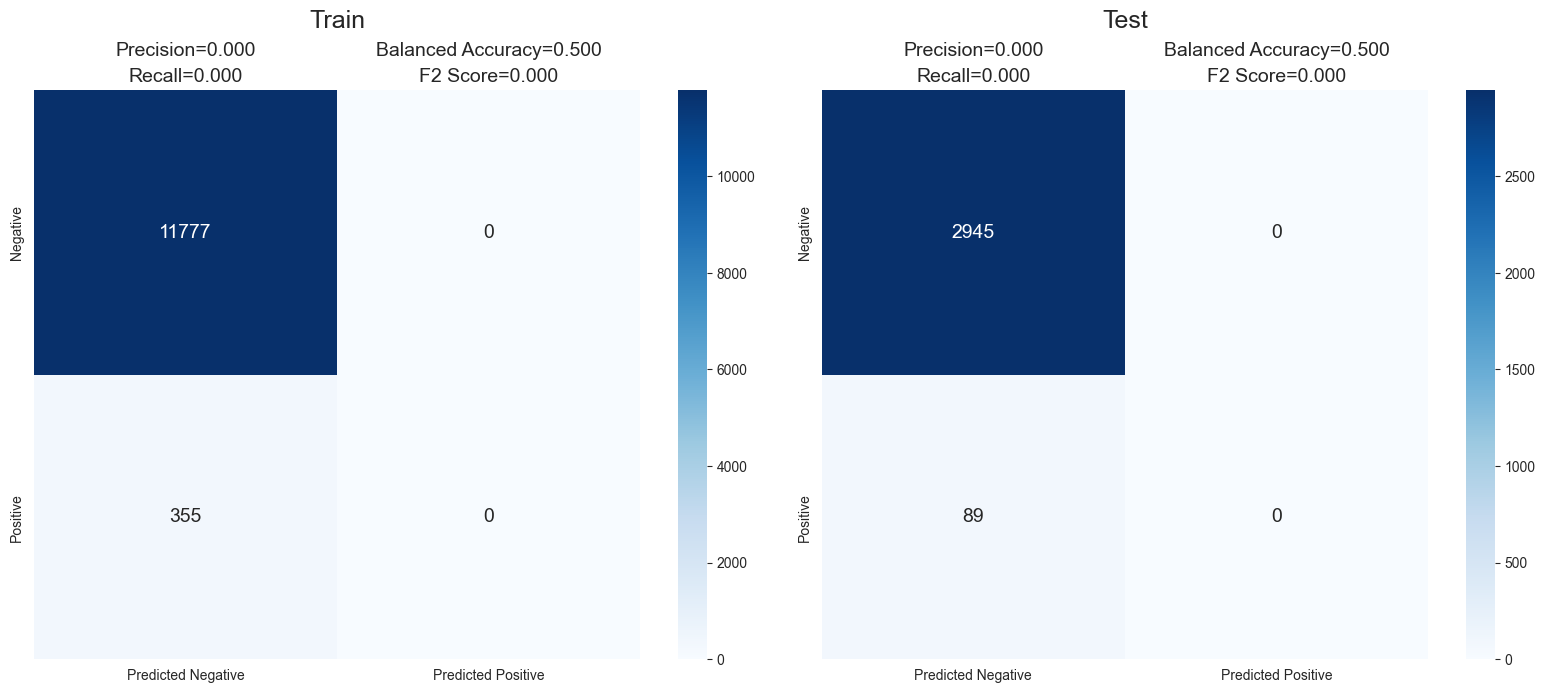

In [42]:
model = LogisticRegression(max_iter=500, random_state=RANDOM_SEED)
model.fit(X_train, y_train)
plot_confusion_matrices(model, (X_train, X_test, y_train, y_test))

Due to the highly imbalanced nature of the dataset, the model classifies all observations as belonging to the negative class, as evidenced by the confusion matrices in both the training and test sets.

Here, **balanced accuracy** is considered instead of accuracy, which avoids inflated performance estimates on imbalanced datasets. It is the macro-average of recall scores per class. In the binary case, balanced accuracy is equal to the arithmetic mean of sensitivity (true positive rate) and specificity (true negative rate):
$$
\text{balanced accuracy} = \frac{1}{2}\left(\frac{TP}{TP+FN}+\frac{TN}{TN+FP}\right)
$$
Furthermore, let's assume that our client has requested a conservative approach, meaning they want to take minimal risks and avoid providing credit cards to unreliable individuals.

Furthermore, it has been opted to utilize the **F2 score** instead of the traditional **F1 score**, that is given by:
$$
F_\beta=(1+\beta^2)\cdot\frac{\text{precision}\cdot\text{recall}}{(\beta^2\cdot\text{precision})+\text{recall}}
$$
with $\beta=2$, which weighs recall higher than precision. The reason is that having a false negative means to classify individuals as reliable when they are not and, in this way, the minimization of false negatives is prioritized.

As first attempt, let's address the class imbalance by configuring the `class_weight` parameter with the value `'balanced'`. This setting automatically adjusts the weights based on the class frequencies in the input data, using the values of `y`.

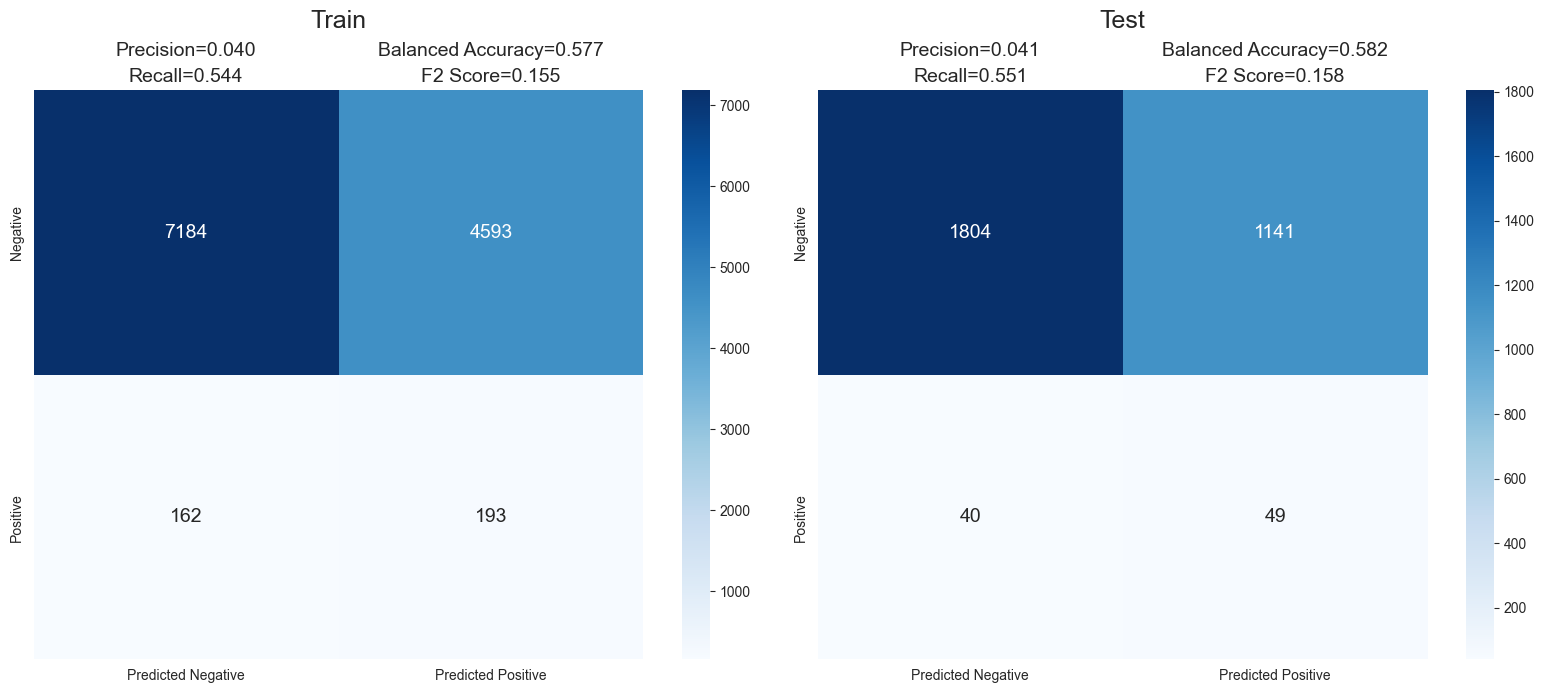

In [43]:
model = LogisticRegression(class_weight = 'balanced', max_iter=500, random_state=RANDOM_SEED)
model.fit(X_train, y_train)
plot_confusion_matrices(model, (X_train, X_test, y_train, y_test))

Even though we set the `class_weight` parameter to `'balanced'`, both the precision and recall values are low, and the balanced accuracy is equal to around 0.58.

Before moving to another type of model, let us try to handle the class imbalance problem by randomly resampling the training dataset. We will perform four different resampling techniques and, for each of them, we will consider 3 different values of `C`, i.e. the inverse of the regularization strength. The four different resampling techniques are:
* Undersampling with `sampling_strategy=0.2`;
* Oversampling with `sampling_strategy=0.2`;
* Oversampling with `sampling_strategy=0.1` followed by undersampling with `sampling_strategy=0.2`;
* SMOTENC with `sampling_strategy=0.2`.

In [44]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTENC

In [45]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

results_df = pd.DataFrame(columns=['model', 'balanced_acc_train', 'balanced_acc_test', 'precision_train', 'precision_test', 'recall_train', 'recall_test'])
cat_indices = [num for num in range(X_train.shape[1]) if num not in range(final_columns.index('CNT_CHILDREN'),final_columns.index('CNT_FAM_MEMBERS')+1)]
Cs = np.logspace(-3,3,num=3,base=10).tolist()

resampling_methods = [
    (RandomUnderSampler(sampling_strategy=0.2, random_state=RANDOM_SEED), "undersampling"),
    (RandomOverSampler(sampling_strategy=0.2, random_state=RANDOM_SEED), "oversampling"),
    ((RandomOverSampler(sampling_strategy=0.1, random_state=RANDOM_SEED), 
      RandomUnderSampler(sampling_strategy=0.2, random_state=RANDOM_SEED)), "over_under"),
    (SMOTENC(categorical_features=cat_indices, sampling_strategy=0.2, random_state=RANDOM_SEED), "SMOTENC")
]

print(f"Number of train samples before resampling: {len(y_train)}")
print(f"------------------------------------------------")

for method in resampling_methods:
    resampling, model_name = method
    results_df = train_and_test_lr((X_train, X_test, y_train, y_test),
                                    resampling,
                                    model_name,
                                    Cs,
                                    existing_df=results_df)

Number of train samples before resampling: 12132
------------------------------------------------
Number of train samples after undersampling: 2130
Number of train samples after oversampling: 14132
Number of train samples after over_under: 7062
Number of train samples after SMOTENC: 14132


In [46]:
results_df

,model,balanced_acc_train,balanced_acc_test,precision_train,precision_test,recall_train,recall_test,f2_train,f2_test
0,undersampling_C_0.001,0.569,0.572,0.204,0.037,0.634,0.674,0.446,0.152
1,undersampling_C_1.0,0.574,0.572,0.212,0.039,0.572,0.584,0.427,0.153
2,undersampling_C_1000.0,0.578,0.549,0.215,0.036,0.580,0.539,0.433,0.141
3,oversampling_C_0.001,0.582,0.569,0.214,0.038,0.619,0.607,0.449,0.151
4,oversampling_C_1.0,0.587,0.550,0.223,0.036,0.577,0.506,0.438,0.141
5,oversampling_C_1000.0,0.586,0.549,0.222,0.036,0.575,0.506,0.436,0.140
6,over_under_C_0.001,0.590,0.559,0.217,0.036,0.641,0.584,0.461,0.146
7,over_under_C_1.0,0.591,0.580,0.228,0.041,0.567,0.539,0.437,0.158
8,over_under_C_1000.0,0.591,0.580,0.227,0.041,0.565,0.539,0.436,0.158
9,SMOTENC_C_0.001,0.587,0.509,0.215,0.030,0.637,0.494,0.458,0.122


The configurations with the highest value of the f2 score are over_under_C_1.0 and over_under_C_1000.0. However, it's worth noting that the previous model, trained without the use of resampling techniques, achieved metrics very close to these two models and, in fact, slightly outperformed them in terms of recall and balanced accuracy on the test set. Therefore, we choose that one as the best logistic regression model:

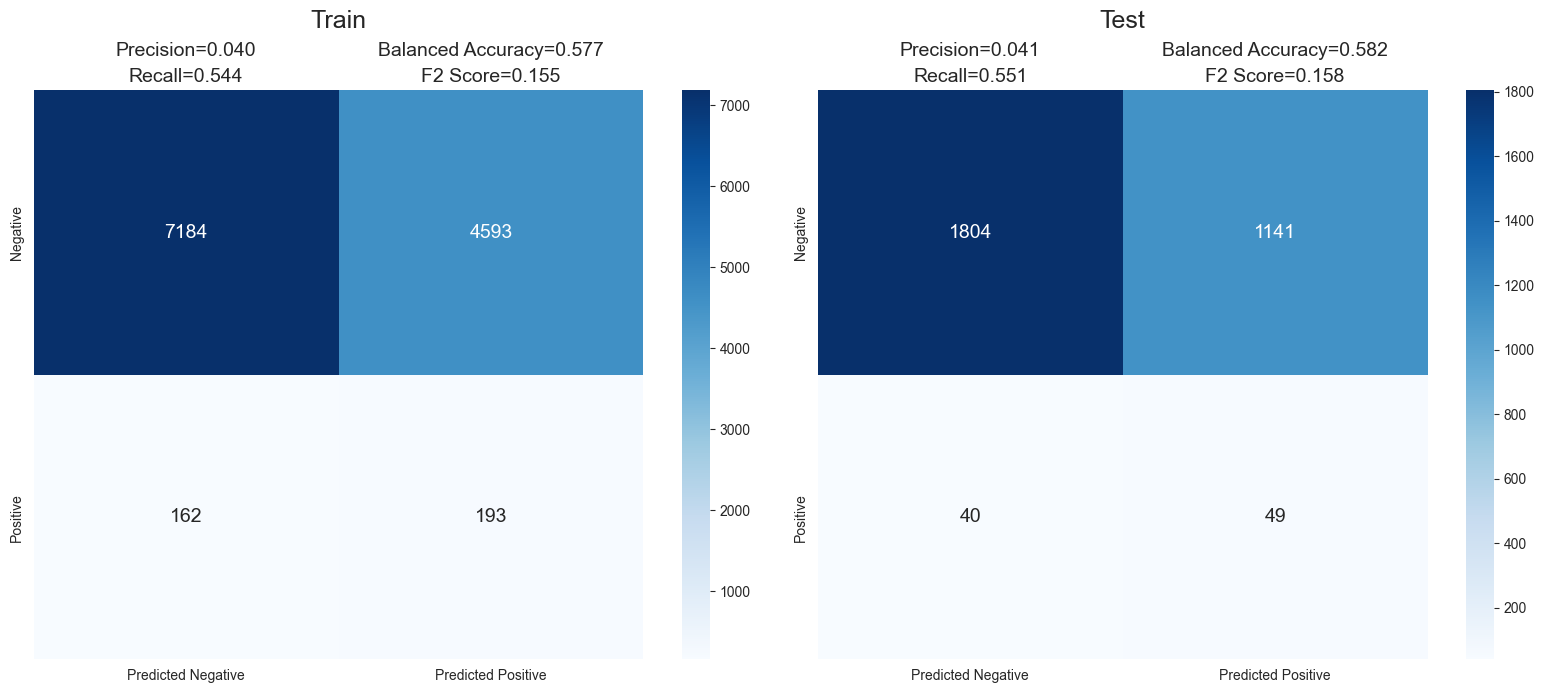

In [47]:
final_lr_model = LogisticRegression(class_weight = 'balanced', max_iter=500, random_state=RANDOM_SEED)
final_lr_model.fit(X_train, y_train)
plot_confusion_matrices(final_lr_model, (X_train, X_test, y_train, y_test))

In [48]:
print("exp(w) for all the features:")
print("----------------------------")
exp_values = [np.exp(coef) for coef in final_lr_model.coef_[0]]
sorted_features = [feature for _, feature in sorted(zip(exp_values, final_columns), reverse=True)]
for feature in sorted_features:
    coef = final_lr_model.coef_[0][final_columns.index(feature)]
    print(f"- {feature}: {np.exp(coef):.3f}")

exp(w) for all the features:
----------------------------
- HOUSING_TYPE_Office apartment: 7.769
- HOUSING_TYPE_Municipal apartment: 4.347
- HOUSING_TYPE_House / apartment: 3.624
- HOUSING_TYPE_With parents: 3.177
- FAMILY_STATUS_Widow: 3.153
- HOUSING_TYPE_Rented apartment: 2.632
- FAMILY_STATUS_Single / not married: 1.961
- CNT_FAM_MEMBERS: 1.522
- FAMILY_STATUS_Separated: 1.279
- FLAG_WORK_PHONE: 1.250
- CODE_GENDER: 1.176
- EDUCATION_TYPE: 0.999
- INCOME_TYPE_Pensioner: 0.994
- AMT_INCOME_TOTAL: 0.969
- AGE: 0.964
- INCOME_TYPE_Working: 0.944
- FLAG_PHONE: 0.931
- INCOME_TYPE_State servant: 0.923
- FAMILY_STATUS_Married: 0.871
- FLAG_OWN_REALTY: 0.858
- FLAG_OWN_CAR: 0.848
- YEARS_EMPLOYED: 0.811
- CNT_CHILDREN: 0.747
- FLAG_EMAIL: 0.742
- INCOME_TYPE_Student: 0.468


The values that deviate the most from 1 (in a positive direction) are `HOUSING_TYPE_Office apartment`, `HOUSING_TYPE_Municipal apartment`, and `HOUSING_TYPE_House / apartment`. This means that, according to this model, the probability of credit unreliability increases if the customer lives in an office apartment, a municipal apartment or a house/apartment (when all other features remain the same).

On the other hand, in the case of `CNT_CHILDREN`, `FLAG_EMAIL`, or `INCOME_TYPE_Student`, the probability of credit unreliability decreases (when all other features remain the same).

## Random Forests and Gradient Boosting Trees

Random Forests and Gradient Boosting Trees are both ensemble learning techniques used in machine learning, but they differ in the way the individual decision trees are built and the results are combined.
* **Random Forests** build multiple decision trees independently and combine their predictions through majority voting for classification or averaging for regression.
* In contrast, **Gradient Boosting Trees** create decision trees sequentially, with each tree correcting the errors of the previous one. This iterative approach aims to minimize the loss function and capture complex relationships in the data.

Let's start by considering two random forests, namely:
1. `RandomForestClassifier` from `sklearn` library;
2. `BalancedRandomForestClassifier` from `imblearn` library.

### Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
rfc = RandomForestClassifier(
    class_weight="balanced",
    random_state=RANDOM_SEED
)

rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=0)

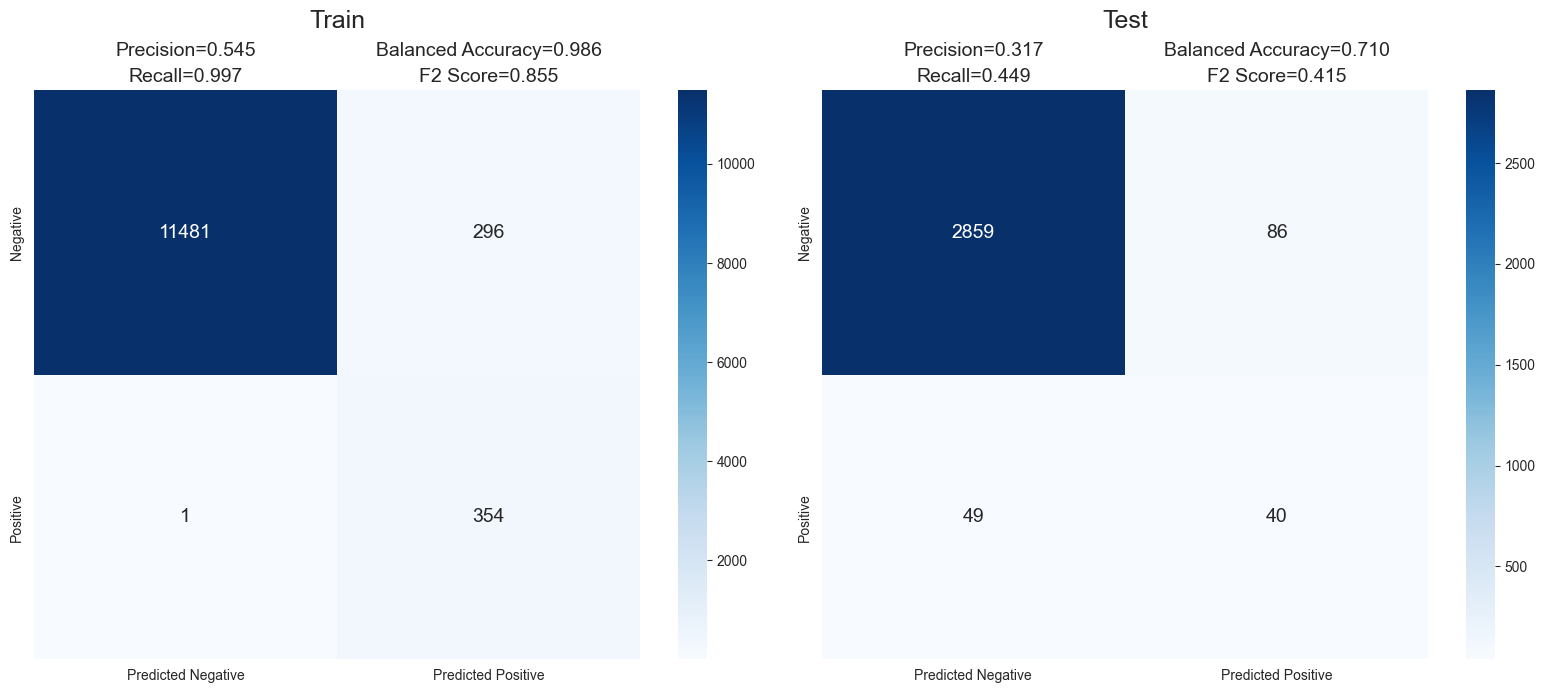

In [51]:
plot_confusion_matrices(rfc, (X_train, X_test, y_train, y_test))

By comparing the metric values on the train and test set, it is clear that we are in presence of overfitting, meaning that the model is too complex and is not able to properly generalize on unseen data. In fact, while in the training set almost all positive observations are classified correctly, the recall drops to 0.449 in the test set. 

To reduce the complexity of the trees, we perform a grid search CV of the following parameter values using the custom function `custom_grid_search`:
* `n_estimators`
* `max_features`
* `max_depth`
* `criterion`

In [52]:
rfc_model = RandomForestClassifier(
    class_weight="balanced",
    random_state=RANDOM_SEED
)

rfc_parameters = {
    'max_features': [None, 'sqrt'],
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'criterion': ["gini", "entropy"]
}

In [53]:
%%time
rfc_models_df = custom_grid_search((X_train_raw, y_train), rfc_model, rfc_parameters, random_state=RANDOM_SEED)

Grid Search Progress: 100%|█████████████████████████████████████████████████| 36/36 [04:29<00:00,  7.49s/configuration]

CPU times: total: 4min 25s
Wall time: 4min 29s


In [54]:
rfc_best_configs = get_best_configs(rfc_models_df)
rfc_best_configs

,mean_train_balanced_acc,mean_test_balanced_acc,std_test_balanced_acc,mean_train_f2,mean_test_f2,std_test_f2,criterion,max_depth,max_features,n_estimators
0,0.984,0.675,0.052,0.872,0.364,0.094,entropy,20,None,100
1,0.987,0.674,0.050,0.875,0.362,0.091,entropy,20,None,200
2,0.987,0.674,0.050,0.873,0.360,0.090,entropy,30,None,100
4,0.972,0.673,0.050,0.857,0.362,0.092,entropy,20,None,50


Among these configurations, Configuration 0 exhibits the highest mean value of both f2 score and balanced accuracy. Consequently, we select Configuration 0 as the optimal choice among the Random Forest models we've trained. Let's train again this model on the entire train set and delve into the results achieved on the test set:

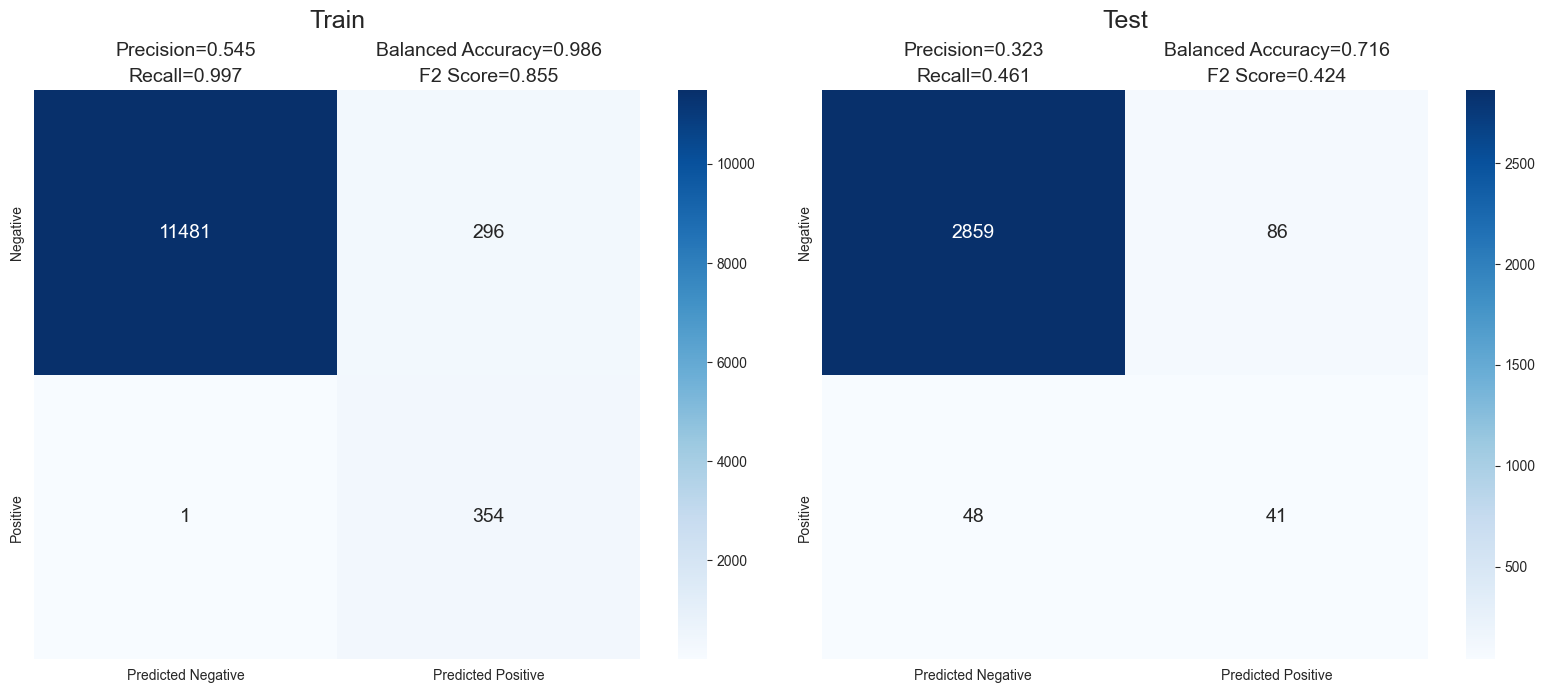

In [70]:
best_rfc_params_dict = get_parameters(rfc_best_configs, 0)
best_rfc_model = RandomForestClassifier(
    class_weight="balanced",
    random_state=RANDOM_SEED,
    **best_rfc_params_dict
)
best_rfc_model.fit(X_train, y_train)
plot_confusion_matrices(best_rfc_model, (X_train, X_test, y_train, y_test))

### Balanced Random Forest

Random forests induce each constituent tree from a bootstrap sample of the training data. However, in cases of extremely imbalanced data, there is a significant probability that a bootstrap sample contains few or even none of the minority class, resulting in a tree with poor performance in predicting the minority class.

The concept of the **Balanced Random Forest (BRF)** algorithm is to ensemble trees that are induced from balanced down-sampled data. For each decision tree, a bootstrap sample from the minority class is drawn, and an equal number of cases are randomly selected, with replacement, from the majority class.

In [56]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [57]:
brf = BalancedRandomForestClassifier(
    random_state=RANDOM_SEED,
    replacement=True
)

brf.fit(X_train, y_train)

BalancedRandomForestClassifier(random_state=0, replacement=True)

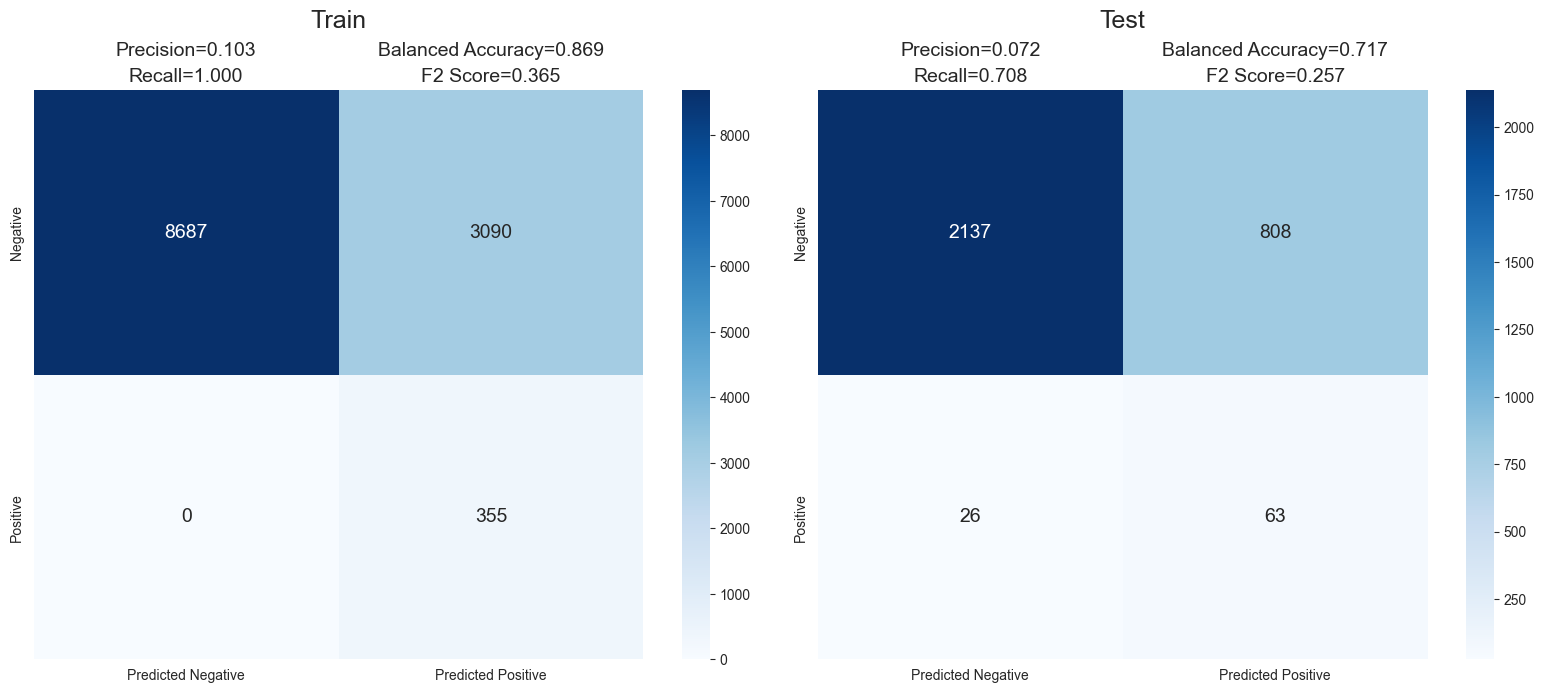

In [58]:
plot_confusion_matrices(brf, (X_train, X_test, y_train, y_test))

While the balanced accuracy value remains similar to the previous case, we observe a significantly higher recall value on the test set (0.708) this time, while the f2 score is significantly lower than before, due to the precision value (0.072).

Let's fine-tune the hyperparameters of the `BalancedRandomForestClassifier` to reduce complexity and enhance its performance in making predictions on unseen data.

In [59]:
brf_model = BalancedRandomForestClassifier(
    random_state=RANDOM_SEED,
    replacement=True
)

brf_parameters = {
    'max_features': [None, 'sqrt'],
    'n_estimators': [50, 100, 200],
    'sampling_strategy': [0.5, 0.65, 0.8, 1.],
    'criterion': ["gini", "entropy"]
}

In [60]:
%%time
brf_models_df = custom_grid_search((X_train_raw, y_train), brf_model, brf_parameters, random_state=RANDOM_SEED)

Grid Search Progress: 100%|█████████████████████████████████████████████████| 48/48 [03:00<00:00,  3.76s/configuration]

CPU times: total: 2min 49s
Wall time: 3min


In [61]:
brf_best_configs = get_best_configs(brf_models_df)
brf_best_configs

,mean_train_balanced_acc,mean_test_balanced_acc,std_test_balanced_acc,mean_train_f2,mean_test_f2,std_test_f2,criterion,max_features,n_estimators,sampling_strategy
0,0.975,0.688,0.047,0.752,0.340,0.068,gini,sqrt,200,0.5
1,0.964,0.687,0.035,0.677,0.315,0.044,entropy,None,50,0.5
2,0.908,0.687,0.039,0.451,0.254,0.033,entropy,None,200,0.8
4,0.976,0.686,0.047,0.757,0.340,0.071,entropy,sqrt,200,0.5
5,0.974,0.686,0.047,0.743,0.332,0.067,gini,sqrt,100,0.5


Configuration 0 attains both the highest mean f2 score and balanced accuracy on the validation set, earning it the designation as the top-performing Balanced Random Forest configuration among those we've trained. Now, let's retrain this model on the complete training dataset and examine the outcomes on the test set:

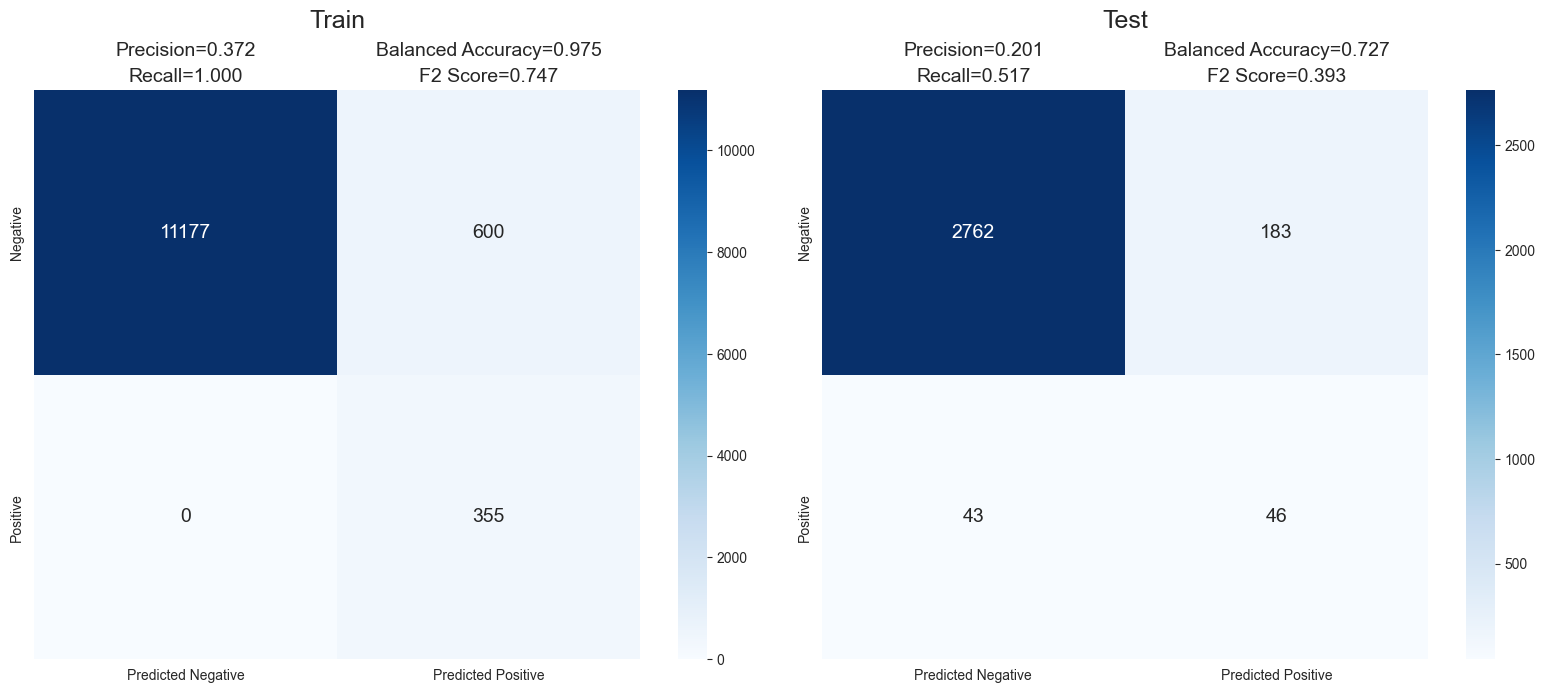

In [62]:
best_brf_params_dict = get_parameters(brf_best_configs, 0)
best_brf_model = BalancedRandomForestClassifier(
    random_state=RANDOM_SEED,
    replacement=True,
    **best_brf_params_dict
)
best_brf_model.fit(X_train, y_train)
plot_confusion_matrices(best_brf_model, (X_train, X_test, y_train, y_test))

## XGBoost

As the last model to be trained, **XGBoost** is chosen.

XGBoost, which stands for "Extreme Gradient Boosting", is a powerful and popular machine learning algorithm that has gained widespread recognition for its effectiveness in a wide range of predictive modeling tasks. It falls under the category of ensemble learning methods: specifically, XGBoost is based on the gradient boosting framework, which combines the predictions of multiple weak models in a sequential manner. It focuses on correcting the errors made by previous models, leading to improved accuracy. 

In particular, XGBoost utilizes **decision tree ensembles**, and the prediction scores assigned to every leaf of each individual tree are summed up to get the final score, for each sample $x_i$. Mathematically, we can write our model in the form
$$
\hat{y}_i=\sum_{k=1}^Kf_k(x_i)
$$
where $K$ is the number of trees and
$$
f_k(x_i)=w_{q(x_i)},\qquad w\in\mathbb{R}^{T_k}
$$
where 
$$
q:\mathbb{R}^d\longrightarrow\{1,2,...,T_k\},\qquad T_k=\text{# of leaves of k-th tree}
$$
is the function assigning each data point to the corresponding leaf. The objective function to be optimized is given by
$$
\text{obj}(\theta)=\sum_{i=1}^n\ell(y_i,\hat{y}_i)+\sum_{k=1}^K\omega(f_k)
$$
where:
* the first term is the **training loss function**,
* the second term is the **regularization term**, which controls the complexity of the model and helps to avoid overfitting, 
* $\theta$ stands for the parameters of the model, which we need to learn from data.

To learn all the trees' parameters, we use an **additive strategy**: we fix what we have learned, and add one new tree at a time. In other words, let's write the prediction value at step $t$ as $\hat{y}_i^{(t)}$. Then, we have
$$
\begin{align}
\hat{y}_i^{(0)}&=0\\
\hat{y}_i^{(1)}&=f_1(x_i)=\hat{y}_i^{(0)}+f_1(x_i)\\
&...\\
\hat{y}_i^{(t)}&=\sum_{k=1}^tf_k(x_i)=\hat{y}_i^{(t-1)}+f_t(x_i)
\end{align}
$$
The tree to add at each step is otained by optimizing our objective function:
$$
\begin{align}
\text{obj}^{(t)}&=\sum_{i=1}^n\ell(y_i,\hat{y}_i^{(t)})+\sum_{j=1}^t\omega(f_j)\\
&=\sum_{i=1}^n\ell(y_i,\hat{y}_i^{(t-1)}+f_t(x_i))+\omega(f_t)+\text{constant}
\end{align}
$$
where $\text{constant}$ contains all the terms that depend only on the previous trees, which are treated as fixed at step $t$. At this point, we take the Taylor expansion of the loss function up to the second order:
$$
\ell(y_i,\hat{y}_i^{(t-1)}+f_t(x_i))\approx\ell(y_i,\hat{y}_i^{(t-1)})+g_if_t(x_i)+\frac{1}{2}h_if_t^2(x_i)
$$
where
$$
g_i=\frac{\partial\ell}{\partial \hat{y}_i^{(t-1)}}(y_i,\hat{y}_i^{(t-1)}),\qquad h_i=\frac{\partial^2\ell}{\partial (\hat{y}_i^{(t-1)})^2}(y_i,\hat{y}_i^{(t-1)})
$$
Therefore, up to a constant term, the objective function is given by:
$$
\text{obj}^{(t)}=\sum_{i=1}^n\left[g_if_t(x_i)+\frac{1}{2}h_if_t^2(x_i)\right]+\omega(f_t)
$$
Finally, we need to specify the form of the regularization term, which keeps under control the complexity of the tree. In XGBoost, we define it as 
$$
\omega(f)=\gamma T+\frac{1}{2}\lambda\sum_{j=1}^Tw_j^2
$$
where:
* $\lambda$ is hyperparameter controlling the L2 regularization term on weights,
* $\gamma$ represents the minimum loss reduction required to make a further partition on a leaf node of the tree.

Putting together what said so far, we obtain the following final formula for the objective function:
$$
\begin{align}
\text{obj}^{(t)}&=\sum_{i=1}^n\left[g_iw_{q(x_i)}+\frac{1}{2}h_iw^2_{q(x_i)}\right]+\gamma T+\frac{1}{2}\sum_{j=1}^Tw_j^2=\\
&=\sum_{j=1}^T\left[\left(\sum_{i\in\text{I}_j}g_i\right)w_j+\frac{1}{2}\left(\sum_{i\in\text{I}_j}h_i+\lambda\right)w_j^2\right]+\gamma T=\\
&=\sum_{j=1}^T\left[G_jw_j+\frac{1}{2}\left(H_j+\lambda\right)w_j^2\right]+\gamma T
\end{align}
$$
where $\text{I}_j=\{i|q(x_i)=j\}$ is the set of indices of data points assigned to the j-th leaf. From this expression, we find that the best $w_j$ for a given structure $q(x)$, i.e. $T$ fixed, is:
$$
w_j^*=-\frac{G_j}{H_j+\lambda},\qquad\text{obj}^*=-\frac{1}{2}\sum_{j=1}^T\frac{G_j^2}{H_j+\lambda}+\gamma T
$$

Now that we have a way to measure how good a tree is, ideally we would enumerate all possible trees and pick the best one. In practice this is intractable, so we will try to optimize one level of the tree at a time. Specifically we try to split a leaf into two leaves, and the score it gains is  
$$
\begin{align}
\text{Gain}&=\text{obj}(\text{before split})-\text{obj}(\text{after split})=\\
&=\frac{1}{2}\left[\frac{G_L^2}{H_L+\lambda}+\frac{G_R^2}{H_R+\lambda}-\frac{(G_L+G_R)^2}{H_L+H_R+\lambda}\right]-\gamma
\end{align}
$$
Therefore, as already said, $\gamma$ represents the minimum loss reduction required to make a further partition on a leaf node of the tree: if the loss reduction is smaller than $\gamma$, we would do better not to add that branch!

Let's train an `XGBClassifier` and look at the results:

In [63]:
import xgboost as xgb
from xgboost import XGBClassifier

In [64]:
xgb = XGBClassifier(
    random_state=RANDOM_SEED
)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

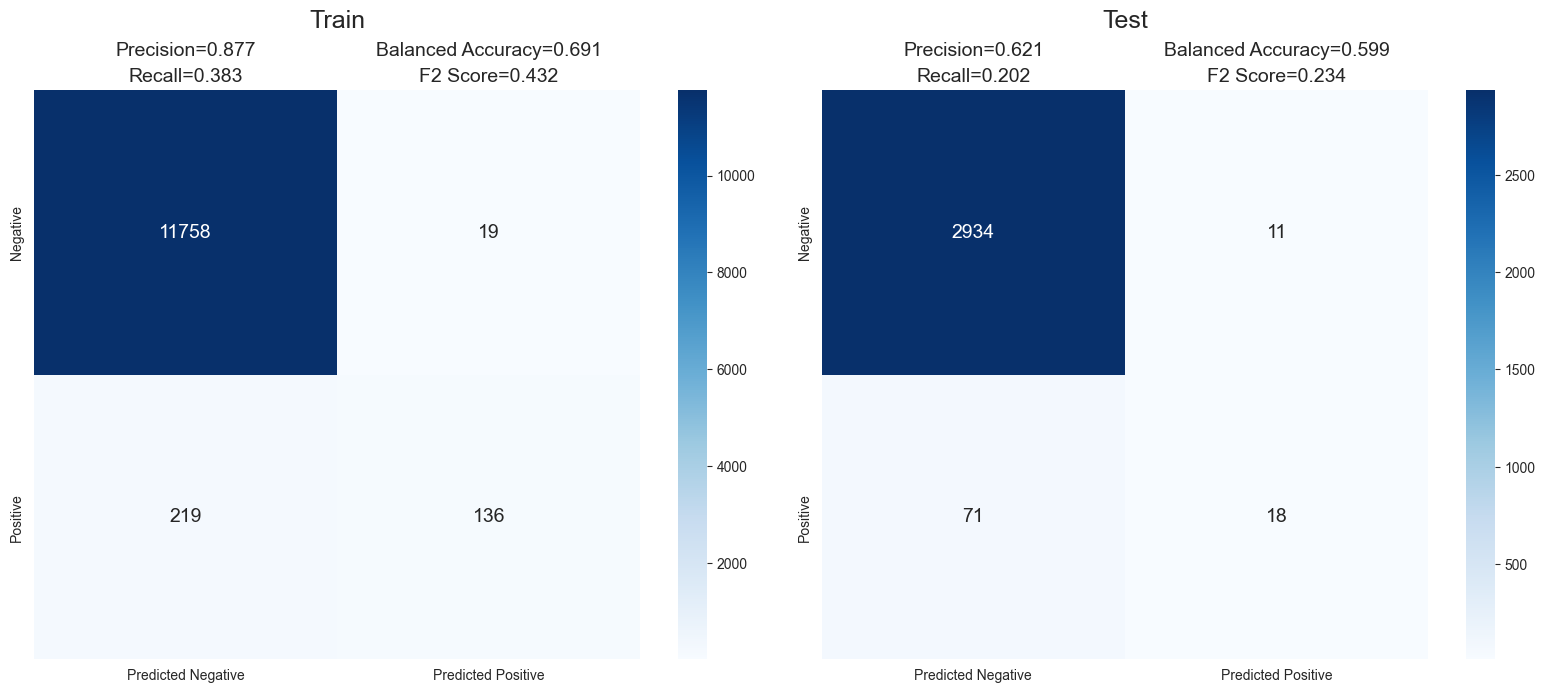

In [65]:
plot_confusion_matrices(xgb, (X_train, X_test, y_train, y_test))

As with the other models, a hyperparameter tuning phase has been carried out, considering the following hyperparameters:
* `learning_rate`: the hyperparameter that controls the step size shrinkage at each iteration of the boosting process. 
* `max_depth`: maximum depth of a tree.
* `scale_pos_weight`: it controls the balance of positive and negative instances, useful for unbalanced classes.
* `lambda`: the hyperparameter controlling the L2 regularization term on weights.

In [66]:
xgb_model = XGBClassifier(
    random_state=RANDOM_SEED
)

xgb_parameters = {
    'learning_rate': [0.01, 0.1, 0.3], # 0.3 default. eta shrinks the feature weights to make the boosting process more conservative.
    'max_depth': [4, 6, 8], # 6 default.
    'scale_pos_weight': [5, 20, 35, 50], # control the balance of positive and negative weights, useful for unbalanced classes.
    'lambda': [0.1, 1, 10] # 1 default. L2 regularization term on weights. Increasing this value will make model more conservative. 
}

In [67]:
%%time
xgb_models_df = custom_grid_search((X_train_raw, y_train), xgb_model, xgb_parameters, random_state=RANDOM_SEED)

Grid Search Progress: 100%|███████████████████████████████████████████████| 108/108 [01:26<00:00,  1.24configuration/s]

CPU times: total: 18min 39s
Wall time: 1min 26s


In [68]:
xgb_best_configs = get_best_configs(xgb_models_df)
xgb_best_configs

,mean_train_balanced_acc,mean_test_balanced_acc,std_test_balanced_acc,mean_train_f2,mean_test_f2,std_test_f2,lambda,learning_rate,max_depth,scale_pos_weight
0,0.984,0.699,0.048,0.822,0.378,0.076,0.1,0.3,6,50
1,0.989,0.693,0.051,0.872,0.387,0.089,1.0,0.3,8,50
2,0.989,0.692,0.045,0.873,0.386,0.076,0.1,0.3,8,50
5,0.989,0.690,0.047,0.874,0.383,0.081,0.1,0.3,8,35


In this case, Configuration 1 is chosen as the best XGBoost configuration, since it has the highest mean f2 score and the second highest mean balanced accuracy score on the validation set. As with the other models, let's train again the model on the entire train set and take a closer look at the results achieved on the test set:

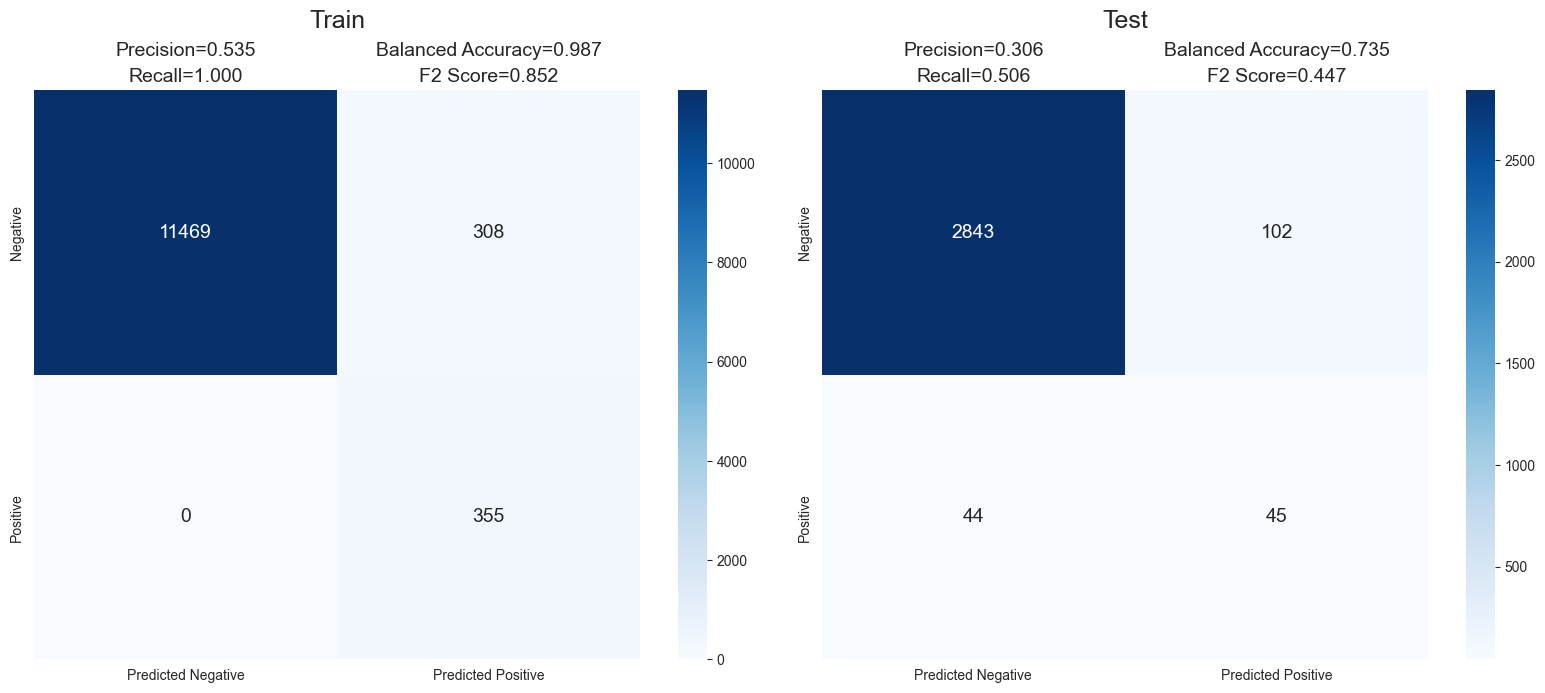

In [73]:
best_xgb_params_dict = get_parameters(xgb_best_configs, 1)
best_xgb_model = XGBClassifier(
    random_state=RANDOM_SEED,
    **best_xgb_params_dict
)
best_xgb_model.fit(X_train, y_train)
plot_confusion_matrices(best_xgb_model, (X_train, X_test, y_train, y_test))

It provides better values of both f2 score and balanced accuracy than the best Balanced Random Forest model. Therefore, we choose `best_xgb_model` as our final model to predict the customers' creditworthiness. 

# Interpreting the Final Model

In conclusion, let's delve into the final model's results to gain insights into why the model produces a particular prediction for a given data point and which features play a crucial role in shaping that prediction. To achieve this, we turn to the **SHAP** (SHapley Additive exPlanations) technique.

SHAP is a machine learning interpretation technique designed to explain how input features contribute to a model's predictions.

The goal of SHAP is to explain the prediction of an instance $X$ by computing the contribution of each feature to the prediction. SHAP computes **SHAP values** for each input feature. These values represent the contribution of each feature to the model's output for a specific data instance, i.e. they quantify how much a specific feature increased or decreased the prediction compared to the model's average prediction.

SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained. The easiest way to see this is through a **waterfall plot** that starts at our background prior expectation for the output of the model $E[f(X)]$ (the mean of all predictions), and then adds features one at a time until we reach the current model output $f(X_i)$ for the data point $X_i$:

In [74]:
import shap
warnings.filterwarnings("ignore", category=UserWarning)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [78]:
final_model = XGBClassifier(
    random_state=RANDOM_SEED,
    **best_xgb_params_dict
)
final_model.fit(X_train, y_train)
explainer = shap.TreeExplainer(final_model)
X_test_df = pd.DataFrame(data=X_test, columns=final_columns)
y_pred_test = final_model.predict(X_test)
shap_values = explainer(X_test_df)

Index: 0
True y: 0
Predicted y: 0


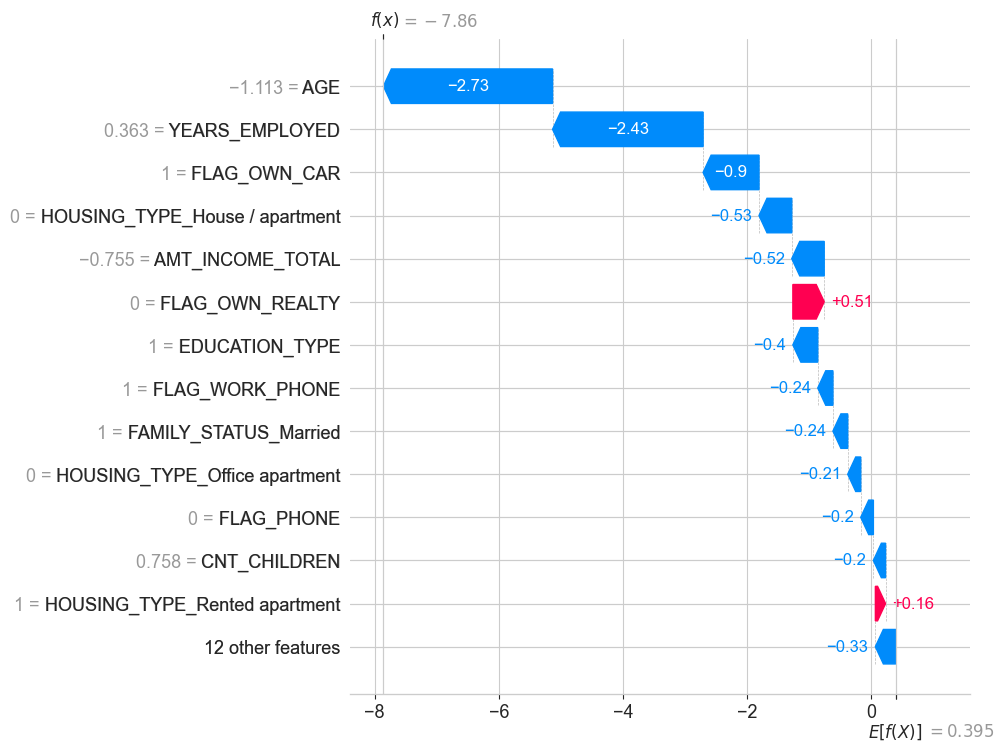

In [79]:
sample_ind = np.where((y_test==0) & (y_pred_test==0))[0][0]
print(f"Index: {sample_ind}")
print(f"True y: {y_test[sample_ind]}")
print(f"Predicted y: {final_model.predict(X_test)[sample_ind]}")
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

The value of $f(X)$ is associated with the probability of credit unreliability through the **sigmoid function**. In fact, if we derived $f(X)$ from the probability value of the observation with index 0, we would obtain exactly the same value:
$$
P(y=1)=\frac{1}{1+e^{-f(X)}}\quad\implies\quad f(X)=\ln\left(\frac{P(y=1)}{1-P(y=1)}\right)
$$

In [80]:
p_1 = final_model.predict_proba(X_test)[sample_ind][1]
p_1, round(np.log(p_1/(1-p_1)),3)

(0.00038587008, -7.86)

For a better interpretation of the waterfall plot, we can recover the initial values of the numeric features, such as `AGE` and `YEARS_EMPLOYED`, as well as `EDUCATION_TYPE`, by employing the `inverse_transform` method of the `preprocessor` instance:

In [81]:
X_test_df_tr = preprocessor.inverse_transform(X_test)
transformed_columns = ['AGE', 'YEARS_EMPLOYED', 'AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'EDUCATION_TYPE']
X_test_df_tr.iloc[sample_ind][transformed_columns]

AGE                                          32.0
YEARS_EMPLOYED                                9.0
AMT_INCOME_TOTAL                         112500.0
CNT_CHILDREN                                  1.0
CNT_FAM_MEMBERS                               3.0
EDUCATION_TYPE      Secondary / secondary special
Name: 0, dtype: object

In this example, we observe that the customer's age of 32, along with nine years of employment and car ownership, significantly decreases his probability of credit unreliability.

Note that these SHAP values are valid for **this observation only**. With other data points the SHAP values will change. In order to understand the importance or contribution of the features for the whole dataset, another plot can be used, the **bee swarm plot**:

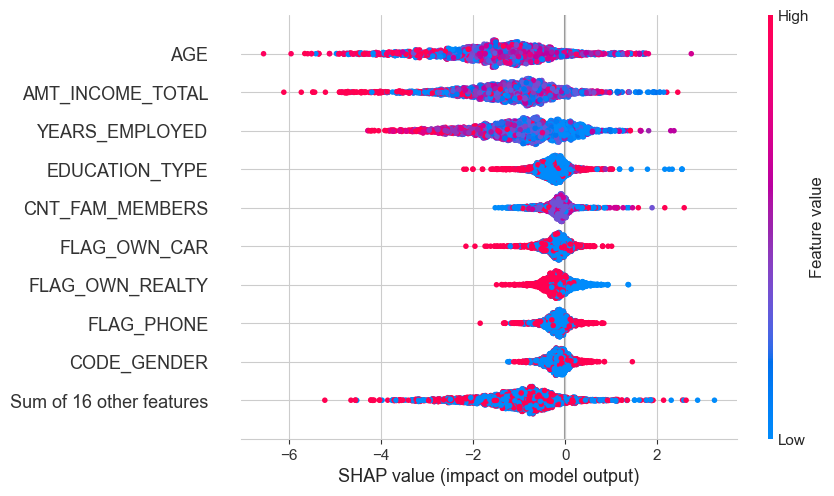

In [82]:
shap.plots.beeswarm(shap_values)

For instance, apart from a few exceptions, high values of the `YEARS_EMPLOYED` variable have a high negative influence on the prediction (as expected), while low values have a less pronounced positive impact or, in certain instances, a negative contribution. On the contrary, it's worth noting how owning real estate (`FLAG_OWN_REALTY` feature) negatively affects the prediction, while not owning it increases the probability of credit unreliability for potential customers.

Lastly, you can obtain an overview of feature importance by creating a **SHAP bar plot**, which calculates the mean absolute value of SHAP values for each feature across all instances (rows) of the dataset:

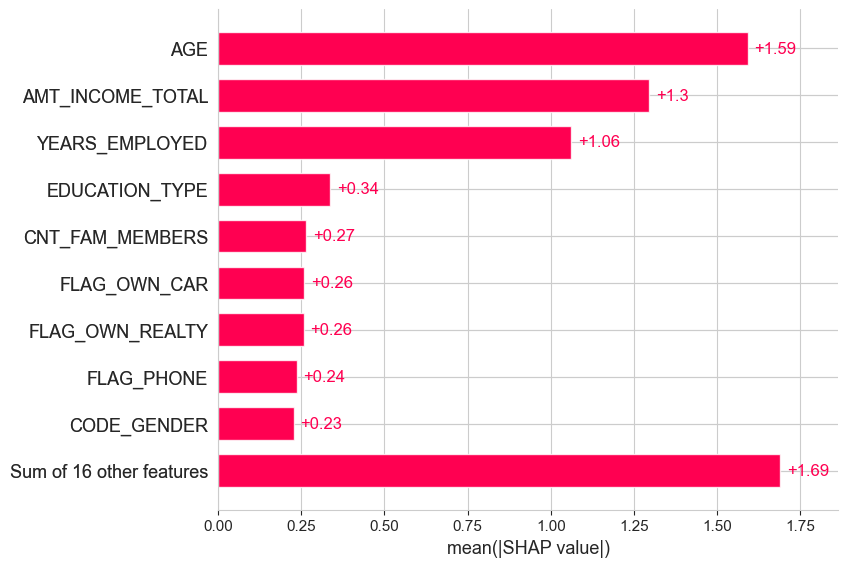

In [83]:
shap.plots.bar(shap_values)

Once more, we observe that `AGE`, `AMT_INCOME_TOTAL`, and `YEARS_EMPLOYED` are the most influential features in assessing a customer's creditworthiness.

This marks the end of this project. Thank you for taking a look and for coming this far :)